In [1]:
# import data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv("pcap_kpis_detailed.csv")

# Quick preview
df.head()


,file,node_type,network_type,total_packets,avg_pkt_size,std_pkt_size,min_pkt_size,max_pkt_size,avg_inter_pkt_time,std_inter_pkt_time,...,unique_src_ports,unique_dst_ports,unique_tos_values,avg_dscp,unique_dscp,non_zero_dscp,dscp_marking_ratio,dns_queries,dns_responses,dns_ratio
0,ap-wifi-5-1.pcap,unknown,unknown,1674,112.021505,83.167136,14,202,0.041743,0.049864,...,0,0,0,0.0,0,0,0.0,0,0,0.0
1,bot-wifi-0-6-1.pcap,bot,wifi,203,79.280788,44.311759,14,134,0.222251,1.560268,...,0,0,0,0.0,0,0,0.0,0,0,0.0
2,bot-wifi-1-8-1.pcap,bot,wifi,270,78.370370,43.502191,14,134,0.166903,1.355483,...,0,0,0,0.0,0,0,0.0,0,0,0.0
3,bot-wifi-10-24-1.pcap,bot,wifi,1134,118.357143,80.620097,14,202,0.042478,0.049791,...,0,0,0,0.0,0,0,0.0,0,0,0.0
4,bot-wifi-11-25-1.pcap,bot,wifi,1275,108.633725,81.758055,14,202,0.037938,0.048852,...,0,0,0,0.0,0,0,0.0,0,0,0.0


# Distributions

## avg_pkt_size distribution (first plot)

 - Humans likely generate a wider range of packet sizes due to varied application use

## avg_inter_pkt_time (second plot)

 - Humans are potentially more likely to have long idle intervals

 - Bots usually operate at very consistent timing

## pkt_size_entropy (third plot)

 - High entropy
   - diverse packet sizes
   - likely human

 - Low entropy
   - repetitive sizes
   - likely bot or automated tools


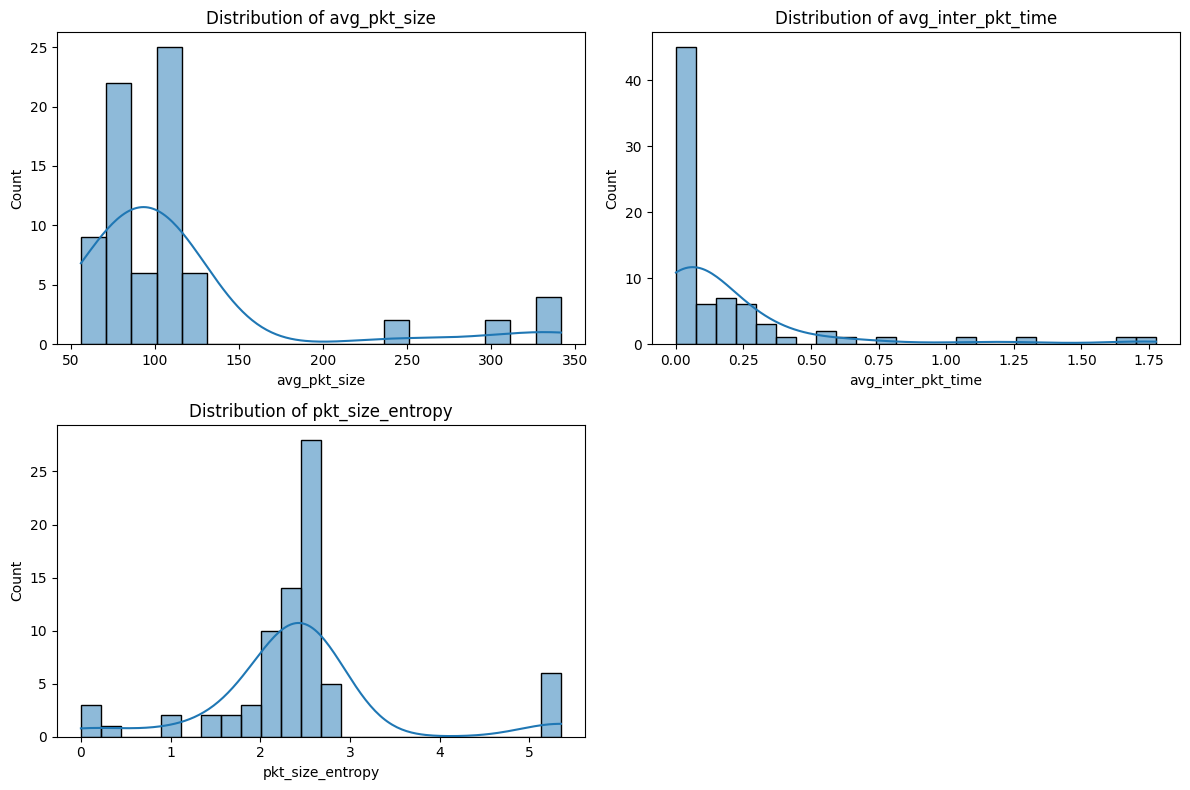

In [2]:
hist_cols = [
    "avg_pkt_size",
    "avg_inter_pkt_time",
    "pkt_size_entropy"
]

plt.figure(figsize=(12, 8))
for i, col in enumerate(hist_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


# boxplots

## avg_pkt_size (plot one)

 - Humans show larger spread and higher outliers

 - Bots have smaller, more compact values

So, Humans send more varied and sometimes larger packets

## timing_regularity (plot two)

 - Bots appear slightly more regular

 - Humans slightly less regular

As expected, bots tend to send packets on predictable schedules

## burst_factor (plot three)

 - Humans show higher max burstiness

 - Bots stay within lower, narrower ranges

Human applications produce more extreme bursts 
 - scrolling, streaming, page loads

## pkt_size_entropy (plot four)

Humans 
 - higher variability in packet sizes
Bots 
 - repetitive behavior
 - low entropy

## avg_inter_pkt_time (plot five)

Bots are more predictable
 - Bots exhibit more uniform behavior
   - Narrow packet-size range
   - Lower entropy
   - More regular timing

Humans generate more bursty, unpredictable traffic
 - Higher variance
 - Outliers in packet sizes, timing, and entropy
 - Bursts in packets-per-second

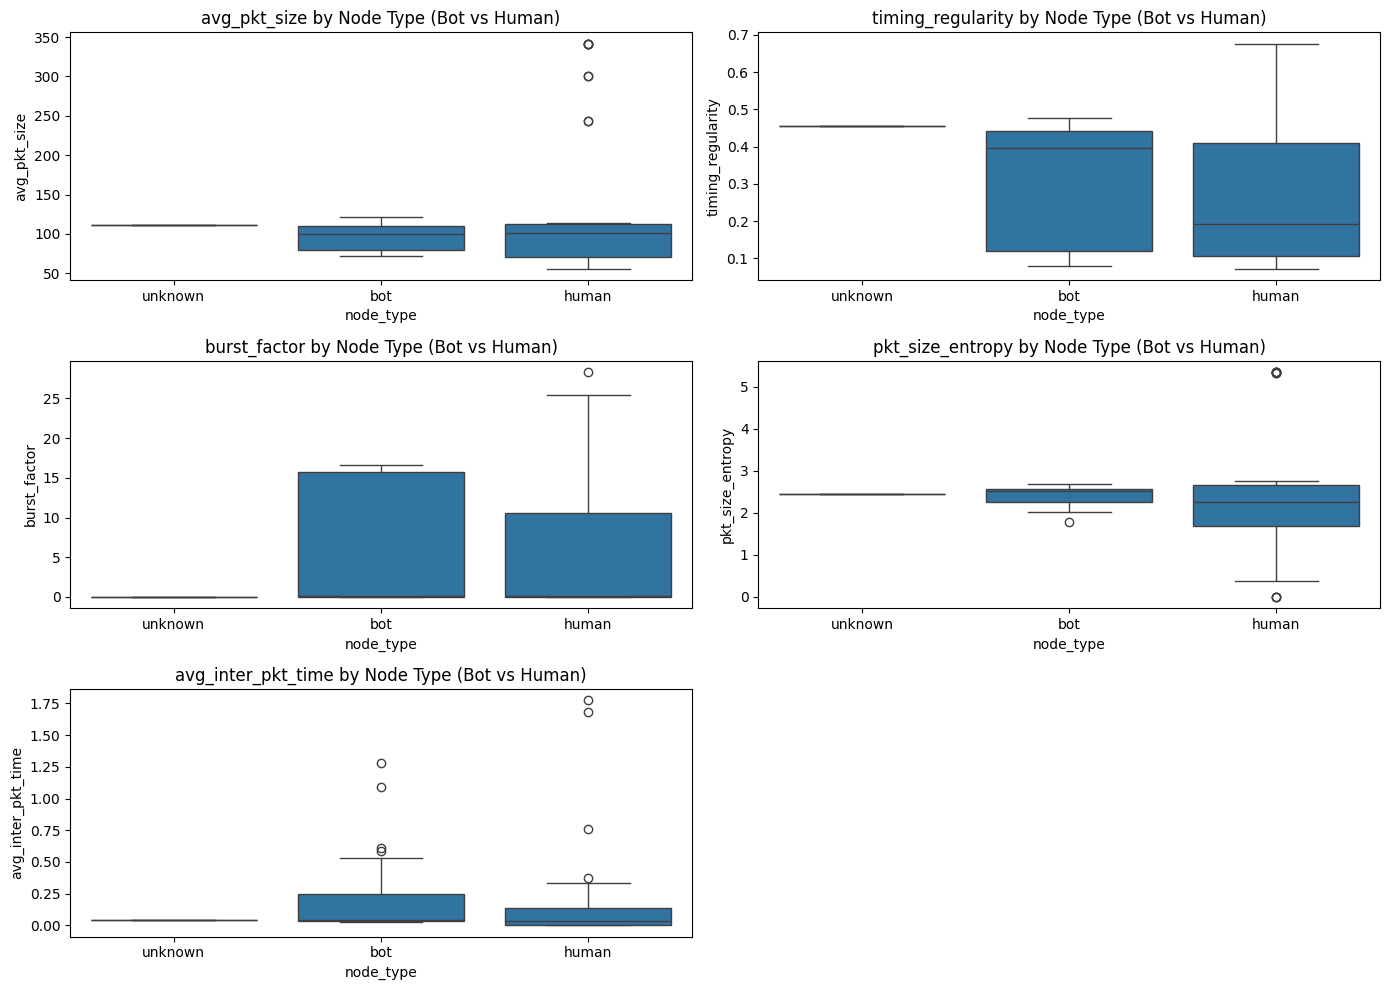

In [3]:
boxplot_cols = [
    "avg_pkt_size",
    "timing_regularity",
    "burst_factor",
    "pkt_size_entropy",
    "avg_inter_pkt_time"
]

plt.figure(figsize=(14, 10))
for i, col in enumerate(boxplot_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df, x="node_type", y=col)
    plt.title(f"{col} by Node Type (Bot vs Human)")
plt.tight_layout()
plt.show()


# bot/human analysis stats

In [4]:
bot_stats = df[df["node_type"] == "bot"].describe()
human_stats = df[df["node_type"] == "human"].describe()

bot_stats, human_stats


(       total_packets  avg_pkt_size  std_pkt_size  min_pkt_size  max_pkt_size  \
 count      39.000000     39.000000     39.000000          39.0     39.000000   
 mean      868.641026     96.854356     63.150063          14.0    172.358974   
 std       635.413561     16.337335     18.910127           0.0     34.160216   
 min        36.000000     71.712766     32.909598          14.0    134.000000   
 25%       184.000000     79.511238     43.430029          14.0    134.000000   
 50%      1149.000000    100.417174     75.283416          14.0    202.000000   
 75%      1346.000000    110.024136     81.337892          14.0    202.000000   
 max      1940.000000    121.713281     82.451094          14.0    202.000000   
 
        avg_inter_pkt_time  std_inter_pkt_time  min_inter_pkt_time  \
 count           39.000000           39.000000           39.000000   
 mean             0.194385            1.027135            0.000049   
 std              0.282791            1.297789            0

In [5]:
features = [
    "avg_inter_pkt_time", "timing_regularity", "timing_cv", "burst_factor",
    "pkt_size_entropy", "src_port_entropy", "dst_port_entropy",
    "tcp_syn_count", "tcp_fin_count", "tcp_rst_count",
    "tcp_ratio", "udp_ratio"
]

df.groupby("node_type")[features].mean().T


node_type,bot,human,unknown
avg_inter_pkt_time,0.194385,0.189606,0.041743
timing_regularity,0.301825,0.243275,0.455677
timing_cv,3.881238,5.128634,1.194538
burst_factor,6.478656,5.994381,0.059565
pkt_size_entropy,2.419492,2.468315,2.449177
src_port_entropy,0.000000,0.158745,0.000000
dst_port_entropy,0.000000,0.159137,0.000000
tcp_syn_count,0.000000,40.222222,0.000000
tcp_fin_count,0.000000,0.000000,0.000000
tcp_rst_count,0.000000,0.000000,0.000000


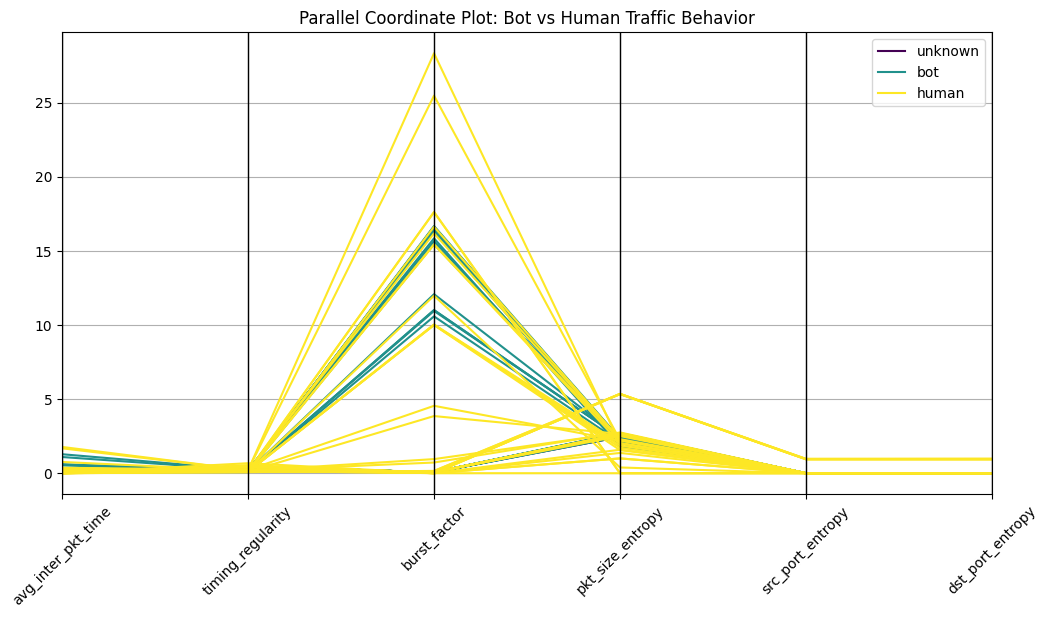

In [6]:
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt

pcp_df = df[[
    "node_type",
    "avg_inter_pkt_time",
    "timing_regularity",
    "burst_factor",
    "pkt_size_entropy",
    "src_port_entropy",
    "dst_port_entropy"
]]

plt.figure(figsize=(12,6))
parallel_coordinates(pcp_df, "node_type", colormap="viridis")
plt.title("Parallel Coordinate Plot: Bot vs Human Traffic Behavior")
plt.xticks(rotation=45)
plt.show()


# wifi vs 5g

## Packets per Second (WiFi vs 5G) (plot one)

- 5G networks tend to support higher stable throughput

- WiFi throughput varies more depending on interference, router load, and signal quality

## Average Inter-Packet Time (Latency pattern) (plot two)

- WiFi shows higher latency and more jitter, which can be expected due to:

    - Shared medium

    - Contention

    - Variable signal strength

- 5G has very low inter-packet time
- packets come in rapid succession
    - low latency

## Burst Factor (plot three)

- WiFi traffic often arrives in bursts due to:

    - MAC-level retransmissions

    - Buffering

    - Random backoff

 - 5G is designed for smooth, high-bandwidth, low-jitter delivery, so bursts flatten out

## Timing CV (Coefficient of Variation) (plot four)

- WiFi has inconsistent timing yet sometimes stable flow
    - CV near 0 for some sessions

- 5G consistently shows very high timing variability
    - CV > 5 for all samples

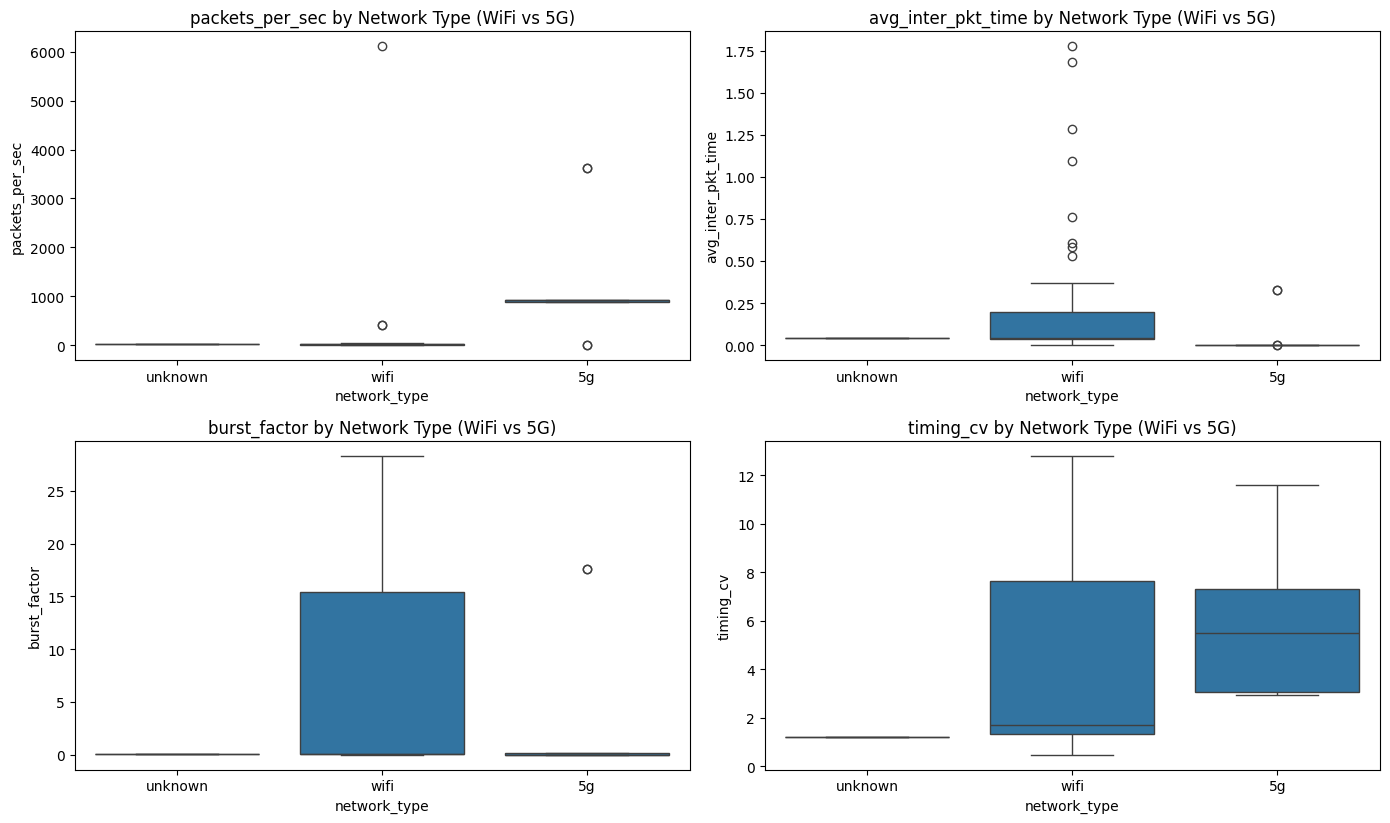

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

compare_cols = [
    "packets_per_sec",
    "avg_inter_pkt_time",
    "burst_factor",
    "timing_cv",
]

plt.figure(figsize=(14, 12))
for i, col in enumerate(compare_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df, x="network_type", y=col)
    plt.title(f"{col} by Network Type (WiFi vs 5G)")
plt.tight_layout()
plt.show()


# Overall, we can conclude

## WiFi Traffic

- More bursty

- Higher latency, larger idle gaps

- More throughput variability

- Very low TTL
    - local LAN traffic

- Timing CV lower on average
    - possibly due to bots

## 5G Traffic

- High stable throughput
    - near 900 pps cluster

- Very low inter-packet times
    - low latency

- Low burstiness

- Very high TTL
    - ~63

- Timing CV surprisingly high
    - likely due to human-generated irregular traffic


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (20, 16)

# Read the CSV file
df = pd.read_csv('bot_detection_kpis.csv', 
                 encoding='utf-8',
                 engine='python',
                 on_bad_lines='skip',
                 skipinitialspace=True)

print(f"Successfully loaded {len(df)} rows")
print(f"Columns: {list(df.columns)}")
print("\n")

# Clean the data - filter out rows with missing node_type
df_clean = df[df['NodeType'].notna()].copy()

Successfully loaded 95 rows
Columns: ['NodeID', 'Username', 'NodeType', 'NetworkType', 'TxPackets', 'RxPackets', 'LostPackets', 'PacketLossRate', 'TotalBytes', 'TweetCount', 'StormTweetCount', 'AvgIAT_s', 'StdIAT_s', 'PlannedWifiPkts', 'Planned5GPkts', 'AvgDelay_ms', 'AvgJitter_ms', 'Throughput_bps', 'TotalDistance_m']




In [9]:
metrics = {
    'PacketLossRate': 'Packet Loss Rate',
    'AvgDelay_ms': 'Average Delay (ms)',
    'AvgJitter_ms': 'Average Jitter (ms)',
    'Throughput_bps': 'Throughput (bps)',
    'AvgIAT_s': 'Avg Inter-Arrival Time (s)',
    'TxPackets': 'Transmitted Packets',
    'RxPackets': 'Received Packets',
    'TotalDistance_m': 'Total Distance (m)'
}

comparison_stats = []
for metric, label in metrics.items():
    bot_data = df_clean[df_clean['NodeType'] == 'bot'][metric].dropna()
    human_data = df_clean[df_clean['NodeType'] == 'human'][metric].dropna()
    
    if len(bot_data) > 0 and len(human_data) > 0:
        bot_mean = bot_data.mean()
        human_mean = human_data.mean()
        diff_pct = ((human_mean - bot_mean) / bot_mean * 100) if bot_mean != 0 else 0
        
        comparison_stats.append({
            'Metric': label,
            'Bot Mean': f"{bot_mean:.2f}",
            'Human Mean': f"{human_mean:.2f}",
            'Bot Median': f"{bot_data.median():.2f}",
            'Human Median': f"{human_data.median():.2f}",
            'Difference': f"{diff_pct:+.1f}%"
        })

stats_df = pd.DataFrame(comparison_stats)

In [10]:
bot_df = df_clean[df_clean['NodeType'] == 'bot']
human_df = df_clean[df_clean['NodeType'] == 'human']

/tmp/ipykernel_44334/1485696607.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot([bot_loss, human_loss], labels=['Bot', 'Human'], patch_artist=True)


AttributeError: 'Axes' object has no attribute 'savefig'

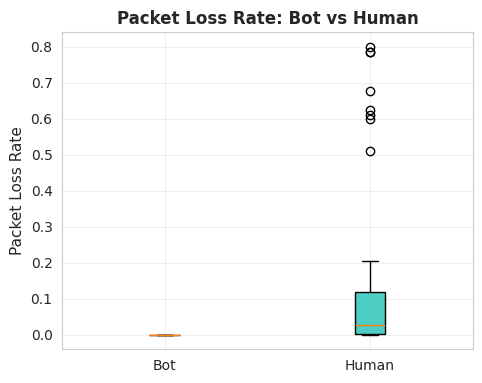

In [11]:
plt.figure(figsize=(18, 14))
ax1 = plt.subplot(3, 3, 1)
bot_loss = bot_df['PacketLossRate'].dropna()
human_loss = human_df['PacketLossRate'].dropna()
bp = ax1.boxplot([bot_loss, human_loss], labels=['Bot', 'Human'], patch_artist=True)
bp['boxes'][0].set_facecolor('#ff6b6b')
bp['boxes'][1].set_facecolor('#4ecdc4')
ax1.set_ylabel('Packet Loss Rate', fontsize=11)
ax1.set_title('Packet Loss Rate: Bot vs Human', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.savefig('packet_loss_rate_bot_vs_human.png')

/tmp/ipykernel_1549/117974751.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot([bot_delay, human_delay], labels=['Bot', 'Human'], patch_artist=True)


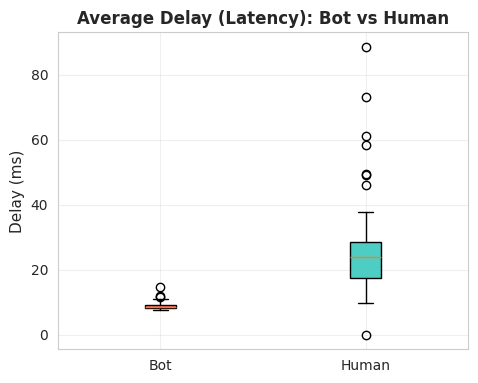

In [ ]:

plt.figure(figsize=(18, 14))
ax2 = plt.subplot(3, 3, 2)
bot_delay = bot_df['AvgDelay_ms'].dropna()
human_delay = human_df['AvgDelay_ms'].dropna()
bp = ax2.boxplot([bot_delay, human_delay], labels=['Bot', 'Human'], patch_artist=True)
bp['boxes'][0].set_facecolor('#ff6b6b')
bp['boxes'][1].set_facecolor('#4ecdc4')
ax2.set_ylabel('Delay (ms)', fontsize=11)
ax2.set_title('Average Delay (Latency): Bot vs Human', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.savefig('avg_delay_bot_vs_human.png')

/tmp/ipykernel_1549/3315896841.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot([bot_throughput, human_throughput], labels=['Bot', 'Human'], patch_artist=True)


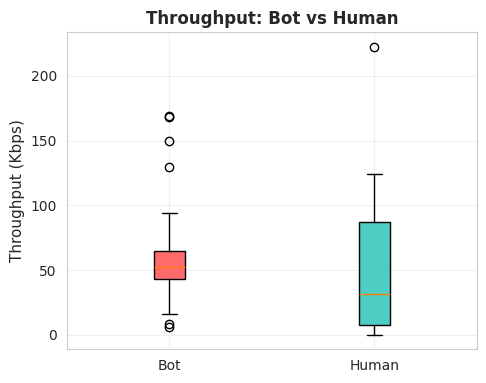

In [ ]:
plt.figure(figsize=(18, 14))
ax3 = plt.subplot(3, 3, 3)
bot_throughput = bot_df['Throughput_bps'].dropna() / 1000  # Convert to Kbps
human_throughput = human_df['Throughput_bps'].dropna() / 1000
bp = ax3.boxplot([bot_throughput, human_throughput], labels=['Bot', 'Human'], patch_artist=True)
bp['boxes'][0].set_facecolor('#ff6b6b')
bp['boxes'][1].set_facecolor('#4ecdc4')
ax3.set_ylabel('Throughput (Kbps)', fontsize=11)
ax3.set_title('Throughput: Bot vs Human', fontweight='bold', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.savefig('throughput_bot_vs_human.png')

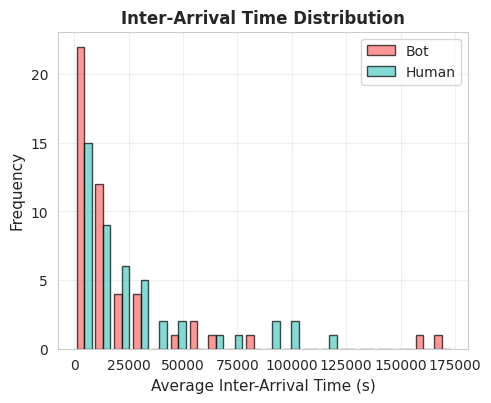

In [ ]:

plt.figure(figsize=(18, 14))
ax4 = plt.subplot(3, 3, 4)
bot_iat = bot_df['AvgIAT_s'].dropna()
human_iat = human_df['AvgIAT_s'].dropna()
ax4.hist([bot_iat, human_iat], bins=20, label=['Bot', 'Human'], 
         color=['#ff6b6b', '#4ecdc4'], alpha=0.7, edgecolor='black')
ax4.set_xlabel('Average Inter-Arrival Time (s)', fontsize=11)
ax4.set_ylabel('Frequency', fontsize=11)
ax4.set_title('Inter-Arrival Time Distribution', fontweight='bold', fontsize=12)
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.savefig('avg_iat_distribution_bot_vs_human.png')

Inter-arrival time is the time between the tweets. Bots have smaller inter-arrival times because the send more tweets/spam

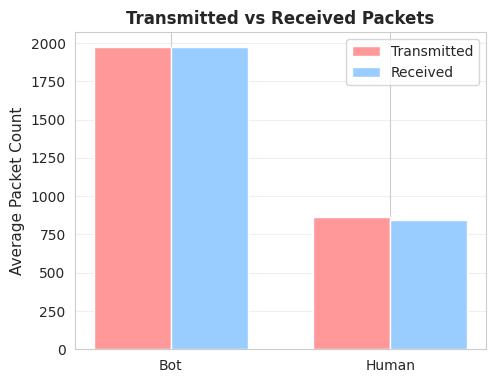

In [ ]:
plt.figure(figsize=(18, 14))
ax5 = plt.subplot(3, 3, 5)
bot_tx = bot_df['TxPackets'].dropna()
bot_rx = bot_df['RxPackets'].dropna()
human_tx = human_df['TxPackets'].dropna()
human_rx = human_df['RxPackets'].dropna()
x = np.arange(2)
width = 0.35
ax5.bar(x - width/2, [bot_tx.mean(), human_tx.mean()], width, label='Transmitted', color='#ff9999')
ax5.bar(x + width/2, [bot_rx.mean(), human_rx.mean()], width, label='Received', color='#99ccff')
ax5.set_ylabel('Average Packet Count', fontsize=11)
ax5.set_title('Transmitted vs Received Packets', fontweight='bold', fontsize=12)
ax5.set_xticks(x)
ax5.set_xticklabels(['Bot', 'Human'])
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')
ax5.savefig('tx_rx_packets_bot_vs_human.png')

/tmp/ipykernel_1549/3844967787.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax6.boxplot([bot_jitter, human_jitter], labels=['Bot', 'Human'], patch_artist=True)


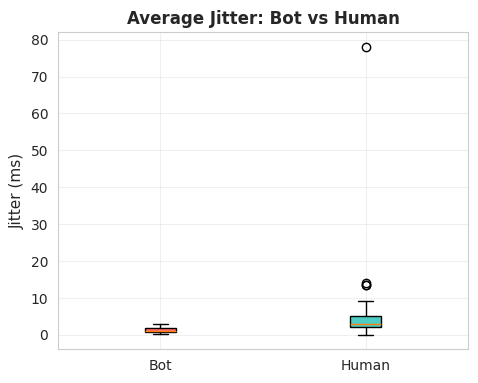

In [ ]:

plt.figure(figsize=(18, 14))
ax6 = plt.subplot(3, 3, 6)
bot_jitter = bot_df['AvgJitter_ms'].dropna()
human_jitter = human_df['AvgJitter_ms'].dropna()
bp = ax6.boxplot([bot_jitter, human_jitter], labels=['Bot', 'Human'], patch_artist=True)
bp['boxes'][0].set_facecolor('#ff6b6b')
bp['boxes'][1].set_facecolor('#4ecdc4')
ax6.set_ylabel('Jitter (ms)', fontsize=11)
ax6.set_title('Average Jitter: Bot vs Human', fontweight='bold', fontsize=12)
ax6.grid(True, alpha=0.3)
ax6.savefig('avg_jitter_bot_vs_human.png')

/tmp/ipykernel_1549/3067854010.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax7.boxplot([bot_distance, human_distance], labels=['Bot', 'Human'], patch_artist=True)


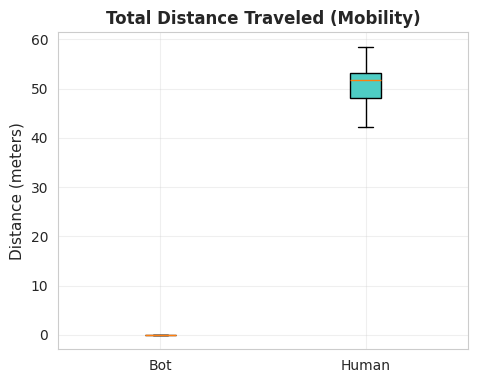

In [ ]:
plt.figure(figsize=(18, 14))
ax7 = plt.subplot(3, 3, 7)
bot_distance = bot_df['TotalDistance_m'].dropna()
human_distance = human_df['TotalDistance_m'].dropna()
bp = ax7.boxplot([bot_distance, human_distance], labels=['Bot', 'Human'], patch_artist=True)
bp['boxes'][0].set_facecolor('#ff6b6b')
bp['boxes'][1].set_facecolor('#4ecdc4')
ax7.set_ylabel('Distance (meters)', fontsize=11)
ax7.set_title('Total Distance Traveled (Mobility)', fontweight='bold', fontsize=12)
ax7.grid(True, alpha=0.3)
ax7.savefig('total_distance_bot_vs_human.png')

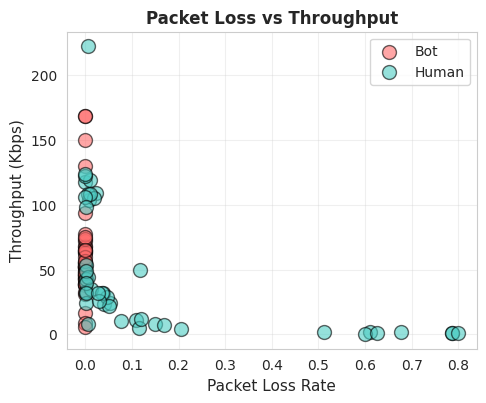

In [ ]:
plt.figure(figsize=(18, 14))

ax8 = plt.subplot(3, 3, 8)
ax8.scatter(bot_df['PacketLossRate'], bot_df['Throughput_bps']/1000, 
           c='#ff6b6b', label='Bot', alpha=0.6, s=100, edgecolors='black')
ax8.scatter(human_df['PacketLossRate'], human_df['Throughput_bps']/1000, 
           c='#4ecdc4', label='Human', alpha=0.6, s=100, edgecolors='black')
ax8.set_xlabel('Packet Loss Rate', fontsize=11)
ax8.set_ylabel('Throughput (Kbps)', fontsize=11)
ax8.set_title('Packet Loss vs Throughput', fontweight='bold', fontsize=12)
ax8.legend()
ax8.grid(True, alpha=0.3)
ax8.savefig('packet_loss_vs_throughput_bot_vs_human.png')


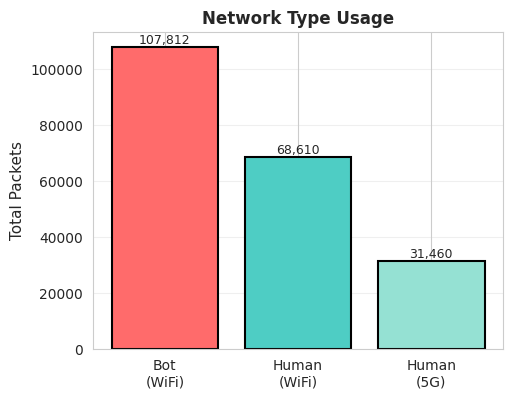

In [ ]:
plt.figure(figsize=(18, 14))

ax9 = plt.subplot(3, 3, 9)
bot_wifi = bot_df['PlannedWifiPkts'].sum()
human_wifi = human_df['PlannedWifiPkts'].sum()
human_5g = human_df['Planned5GPkts'].sum()

categories = ['Bot\n(WiFi)', 'Human\n(WiFi)', 'Human\n(5G)']
values = [bot_wifi, human_wifi, human_5g]
colors = ['#ff6b6b', '#4ecdc4', '#95e1d3']
bars = ax9.bar(categories, values, color=colors, edgecolor='black', linewidth=1.5)
ax9.set_ylabel('Total Packets', fontsize=11)
ax9.set_title('Network Type Usage', fontweight='bold', fontsize=12)
ax9.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax9.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=9)
ax9.savefig('network_type_usage_bot_vs_human.png')